## Imports and paths

In [21]:
import pandas as pd
import numpy as np
import seaborn as sns
import os

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

from pathlib import Path

from IPython.display import Image, display, Video, HTML


In [22]:
!tree -L 3 ..

..
├── Makefile
├── README.md
├── notebooks
│   ├── notebook_exploratory_data_analaysis_benoitfrisque.ipynb
│   ├── notebook_exploratory_data_analaysis_benoitfrisque_copy.ipynb
│   ├── notebook_exploratory_data_analaysis_benoitfrisque_newer.ipynb
│   └── video_conversion_benoitfrisque.ipynb
├── raw_data
│   ├── WLASL_original
│   │   ├── WLASL_v0.3.json
│   │   ├── missing.txt
│   │   ├── nslt_100.json
│   │   ├── nslt_1000.json
│   │   ├── nslt_2000.json
│   │   ├── nslt_300.json
│   │   ├── videos
│   │   └── wlasl_class_list.txt
│   ├── WLASL_processed
│   │   ├── WLASL_v0.3.json
│   │   ├── missing.txt
│   │   ├── nslt_100.json
│   │   ├── nslt_1000.json
│   │   ├── nslt_2000.json
│   │   ├── nslt_300.json
│   │   ├── videos
│   │   └── wlasl_class_list.txt
│   └── google
│       ├── sign_to_prediction_index_map.json
│       ├── train.csv
│       └── train_landmark_files
└── requirements.txt

9 directories, 23 files


In [23]:
DATA_DIR         = Path('../raw_data/google')
TRAIN_CSV_PATH   = DATA_DIR/'train.csv'
LANDMARK_DIR     = DATA_DIR/'train_landmark_files'
LABEL_MAP_PATH   = DATA_DIR/'sign_to_prediction_index_map.json'

## Data description

**Files**

**train_landmark_files/[participant_id]/[sequence_id].parquet** The landmark data. The landmarks were extracted from raw videos with the MediaPipe holistic model. Not all of the frames necessarily had visible hands or hands that could be detected by the model.

Landmark data should not be used to identify or re-identify an individual. Landmark data is not intended to enable any form of identity recognition or store any unique biometric identification.

- `frame` - The frame number in the raw video.
- `row_id` - A unique identifier for the row.
- `type` - The type of landmark. One of ['face', 'left_hand', 'pose', 'right_hand'].
- `landmark_index` - The landmark index number. Details of the hand landmark locations can be found here.
- `[x/y/z]` - The normalized spatial coordinates of the landmark. These are the only columns that will be provided to your submitted model for inference. The MediaPipe model is not fully trained to predict depth so you may wish to ignore the z values.

**train.csv**

- `path` - The path to the landmark file.
- `participant_id` - A unique identifier for the data contributor.
- `sequence_id` - A unique identifier for the landmark sequence.
- `sign` - The label for the landmark sequence.

## List of videos

In [37]:
train = pd.read_csv(TRAIN_CSV_PATH)
train = train[train['participant_id']==16069]  # just small sample
train

,path,participant_id,sequence_id,sign
2,train_landmark_files/16069/100015657.parquet,16069,100015657,cloud
54,train_landmark_files/16069/1002113535.parquet,16069,1002113535,another
101,train_landmark_files/16069/10042041.parquet,16069,10042041,green
102,train_landmark_files/16069/1004211348.parquet,16069,1004211348,bug
110,train_landmark_files/16069/100438640.parquet,16069,100438640,penny
...,...,...,...,...
94304,train_landmark_files/16069/992978889.parquet,16069,992978889,owl
94349,train_landmark_files/16069/994644831.parquet,16069,994644831,nose
94380,train_landmark_files/16069/995944699.parquet,16069,995944699,clean
94427,train_landmark_files/16069/997697271.parquet,16069,997697271,car


In [72]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4848 entries, 2 to 94431
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   path            4848 non-null   object
 1   participant_id  4848 non-null   int64 
 2   sequence_id     4848 non-null   int64 
 3   sign            4848 non-null   object
 4   file_path       4848 non-null   object
dtypes: int64(2), object(3)
memory usage: 356.3+ KB


In [38]:
train.nunique()

path              4848
participant_id       1
sequence_id       4848
sign               250
dtype: int64

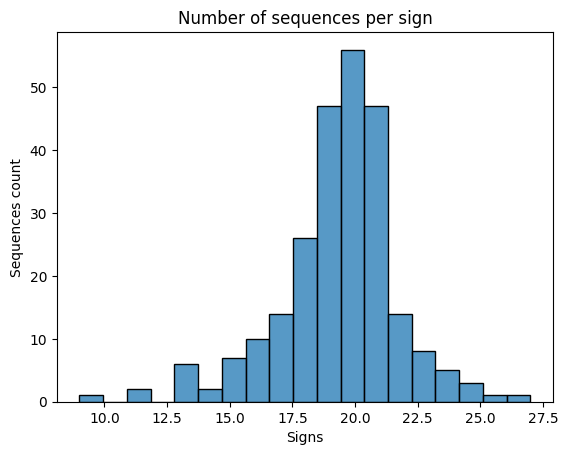

In [39]:
sns.histplot(train[['sign']].value_counts())
plt.title('Number of sequences per sign')
plt.xlabel('Signs')
plt.ylabel('Sequences count');

## List of signs

In [40]:
labels_df = pd.read_json(LABEL_MAP_PATH, orient='index').reset_index().set_index(0).rename(columns={'index':'sign'})
labels_df.index.rename('index', inplace=True)
labels_df

,sign
index,
0,TV
1,after
2,airplane
3,all
4,alligator
...,...
245,yesterday
246,yourself
247,yucky


## Analysis of landmark files

In [71]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4848 entries, 2 to 94431
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   path            4848 non-null   object
 1   participant_id  4848 non-null   int64 
 2   sequence_id     4848 non-null   int64 
 3   sign            4848 non-null   object
 4   file_path       4848 non-null   object
dtypes: int64(2), object(3)
memory usage: 356.3+ KB


In [61]:
train[['file_path']] = str(DATA_DIR) + '/' + train[['path']]

In [68]:
train['file_path']

2        ../raw_data/google/train_landmark_files/16069/...
54       ../raw_data/google/train_landmark_files/16069/...
101      ../raw_data/google/train_landmark_files/16069/...
102      ../raw_data/google/train_landmark_files/16069/...
110      ../raw_data/google/train_landmark_files/16069/...
                               ...                        
94304    ../raw_data/google/train_landmark_files/16069/...
94349    ../raw_data/google/train_landmark_files/16069/...
94380    ../raw_data/google/train_landmark_files/16069/...
94427    ../raw_data/google/train_landmark_files/16069/...
94431    ../raw_data/google/train_landmark_files/16069/...
Name: file_path, Length: 4848, dtype: object

In [78]:
train.loc[2, "file_path"]

'../raw_data/google/train_landmark_files/16069/100015657.parquet'

In [84]:
data = pd.read_parquet(train.loc[2, "file_path"])
data.isna().sum()

frame                0
row_id               0
type                 0
landmark_index       0
x                 3822
y                 3822
z                 3822
dtype: int64

In [75]:
# Source: https://www.kaggle.com/competitions/asl-signs/overview/evaluation
ROWS_PER_FRAME = 543

def load_relevant_data_subset(pq_path):
    data_columns = ['x', 'y', 'z']
    data = pd.read_parquet(pq_path, columns=data_columns)
    n_frames = int(len(data) / ROWS_PER_FRAME)
    data = data.values.reshape(n_frames, ROWS_PER_FRAME, len(data_columns))
    return data.astype(np.float32)

In [92]:
data_clean = load_relevant_data_subset(train.loc[2, "file_path"])
type(data_clean), data_clean
#data_clean

(numpy.ndarray,
 array([[[ 0.4378861 ,  0.43759912, -0.05113366],
         [ 0.4432577 ,  0.39290097, -0.06705423],
         [ 0.44399714,  0.40999812, -0.04298994],
         ...,
         [        nan,         nan,         nan],
         [        nan,         nan,         nan],
         [        nan,         nan,         nan]],
 
        [[ 0.435957  ,  0.43890852, -0.05416486],
         [ 0.44422486,  0.39755237, -0.07172121],
         [ 0.44527793,  0.415623  , -0.04703533],
         ...,
         [        nan,         nan,         nan],
         [        nan,         nan,         nan],
         [        nan,         nan,         nan]],
 
        [[ 0.43828043,  0.4383376 , -0.05458482],
         [ 0.4435466 ,  0.38931727, -0.06934147],
         [ 0.44352257,  0.40743604, -0.04615672],
         ...,
         [        nan,         nan,         nan],
         [        nan,         nan,         nan],
         [        nan,         nan,         nan]],
 
        ...,
 
        [[ 0.41318

In [93]:
np.nan_to_num(data_clean, copy=False)
print(data_clean)

[[[ 0.4378861   0.43759912 -0.05113366]
  [ 0.4432577   0.39290097 -0.06705423]
  [ 0.44399714  0.40999812 -0.04298994]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 [[ 0.435957    0.43890852 -0.05416486]
  [ 0.44422486  0.39755237 -0.07172121]
  [ 0.44527793  0.415623   -0.04703533]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 [[ 0.43828043  0.4383376  -0.05458482]
  [ 0.4435466   0.38931727 -0.06934147]
  [ 0.44352257  0.40743604 -0.04615672]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 ...

 [[ 0.41318083  0.45501623 -0.05196278]
  [ 0.40199342  0.41056907 -0.07530738]
  [ 0.40588465  0.42584985 -0.04541195]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 [

In [80]:
data_clean = load_relevant_data_subset(train.loc[2, "file_path"])
data_clean.shape # number of frames, number of landmarks, # coordinates (x, y, z)

(105, 543, 3)

In [14]:
# # Source: https://www.kaggle.com/competitions/asl-signs/overview/evaluation
# import tflite_runtime.interpreter as tflite
# interpreter = tflite.Interpreter(model_path)

# found_signatures = list(interpreter.get_signature_list().keys())

# if REQUIRED_SIGNATURE not in found_signatures:
#     raise KernelEvalException('Required input signature not found.')

# prediction_fn = interpreter.get_signature_runner("serving_default")
# output = prediction_fn(inputs=frames)
# sign = np.argmax(output["outputs"])


### Landmarks visualization (animation)

In [81]:
def get_hand_points(hand):
    x = [[hand.iloc[0].x, hand.iloc[1].x, hand.iloc[2].x, hand.iloc[3].x, hand.iloc[4].x], # Thumb
         [hand.iloc[5].x, hand.iloc[6].x, hand.iloc[7].x, hand.iloc[8].x], # Index
         [hand.iloc[9].x, hand.iloc[10].x, hand.iloc[11].x, hand.iloc[12].x],
         [hand.iloc[13].x, hand.iloc[14].x, hand.iloc[15].x, hand.iloc[16].x],
         [hand.iloc[17].x, hand.iloc[18].x, hand.iloc[19].x, hand.iloc[20].x],
         [hand.iloc[0].x, hand.iloc[5].x, hand.iloc[9].x, hand.iloc[13].x, hand.iloc[17].x, hand.iloc[0].x]]

    y = [[hand.iloc[0].y, hand.iloc[1].y, hand.iloc[2].y, hand.iloc[3].y, hand.iloc[4].y],  #Thumb
         [hand.iloc[5].y, hand.iloc[6].y, hand.iloc[7].y, hand.iloc[8].y], # Index
         [hand.iloc[9].y, hand.iloc[10].y, hand.iloc[11].y, hand.iloc[12].y],
         [hand.iloc[13].y, hand.iloc[14].y, hand.iloc[15].y, hand.iloc[16].y],
         [hand.iloc[17].y, hand.iloc[18].y, hand.iloc[19].y, hand.iloc[20].y],
         [hand.iloc[0].y, hand.iloc[5].y, hand.iloc[9].y, hand.iloc[13].y, hand.iloc[17].y, hand.iloc[0].y]]

    return x, y

def get_pose_points(pose):
    x = [[pose.iloc[8].x, pose.iloc[6].x, pose.iloc[5].x, pose.iloc[4].x, pose.iloc[0].x, pose.iloc[1].x, pose.iloc[2].x, pose.iloc[3].x, pose.iloc[7].x],
         [pose.iloc[10].x, pose.iloc[9].x],
         [pose.iloc[22].x, pose.iloc[16].x, pose.iloc[20].x, pose.iloc[18].x, pose.iloc[16].x, pose.iloc[14].x, pose.iloc[12].x,
          pose.iloc[11].x, pose.iloc[13].x, pose.iloc[15].x, pose.iloc[17].x, pose.iloc[19].x, pose.iloc[15].x, pose.iloc[21].x],
         [pose.iloc[12].x, pose.iloc[24].x, pose.iloc[26].x, pose.iloc[28].x, pose.iloc[30].x, pose.iloc[32].x, pose.iloc[28].x],
         [pose.iloc[11].x, pose.iloc[23].x, pose.iloc[25].x, pose.iloc[27].x, pose.iloc[29].x, pose.iloc[31].x, pose.iloc[27].x],
         [pose.iloc[24].x, pose.iloc[23].x]
        ]

    y = [[pose.iloc[8].y, pose.iloc[6].y, pose.iloc[5].y, pose.iloc[4].y, pose.iloc[0].y, pose.iloc[1].y, pose.iloc[2].y, pose.iloc[3].y, pose.iloc[7].y],
         [pose.iloc[10].y, pose.iloc[9].y],
         [pose.iloc[22].y, pose.iloc[16].y, pose.iloc[20].y, pose.iloc[18].y, pose.iloc[16].y, pose.iloc[14].y, pose.iloc[12].y,
          pose.iloc[11].y, pose.iloc[13].y, pose.iloc[15].y, pose.iloc[17].y, pose.iloc[19].y, pose.iloc[15].y, pose.iloc[21].y],
         [pose.iloc[12].y, pose.iloc[24].y, pose.iloc[26].y, pose.iloc[28].y, pose.iloc[30].y, pose.iloc[32].y, pose.iloc[28].y],
         [pose.iloc[11].y, pose.iloc[23].y, pose.iloc[25].y, pose.iloc[27].y, pose.iloc[29].y, pose.iloc[31].y, pose.iloc[27].y],
         [pose.iloc[24].y, pose.iloc[23].y]
        ]

    return x, y

In [82]:
sign = data
sign.y = sign.y * -1 # reverse vertically

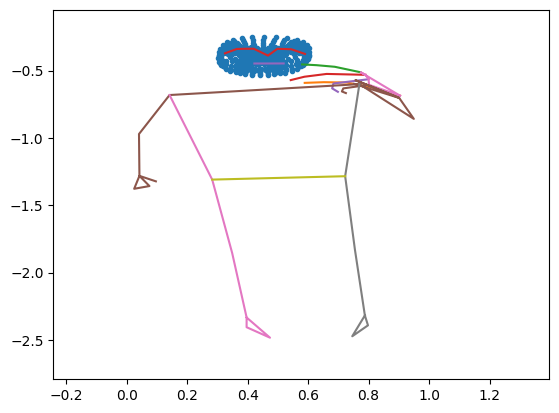

In [83]:

def animation_frame(f):
    frame = sign[sign.frame==f]
    left = frame[frame.type=='left_hand']
    right = frame[frame.type=='right_hand']
    pose = frame[frame.type=='pose']
    face = frame[frame.type=='face'][['x', 'y']].values
    lx, ly = get_hand_points(left)
    rx, ry = get_hand_points(right)
    px, py = get_pose_points(pose)
    ax.clear()
    ax.plot(face[:,0], face[:,1], '.')
    for i in range(len(lx)):
        ax.plot(lx[i], ly[i])
    for i in range(len(rx)):
        ax.plot(rx[i], ry[i])
    for i in range(len(px)):
        ax.plot(px[i], py[i])
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)

## These values set the limits on the graph to stabilize the video
xmin = sign.x.min() - 0.2
xmax = sign.x.max() + 0.2
ymin = sign.y.min() - 0.2
ymax = sign.y.max() + 0.2

fig, ax = plt.subplots(1)
l, = ax.plot([], [])
animation = FuncAnimation(fig,
                          func=animation_frame, frames=sign.frame.unique())

HTML(animation.to_html5_video())